In [4]:
from numpy import expand_dims
from numpy.random import uniform
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import concatenate
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras import layers
from keras import metrics
from keras import activations
from keras.layers import BatchNormalization
from keras.regularizers import l2
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model

# Downloading database
first we download CIFAR-10 database which comprised of 60000 32*32 pixel images
from 10 classes such as frogs, birds, cats, ships, airplanes, etc.
50k images are used for training and 10k are used for test
after dwnloading database we plot 49 images

170500096/170498071 [==============================] - 11s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


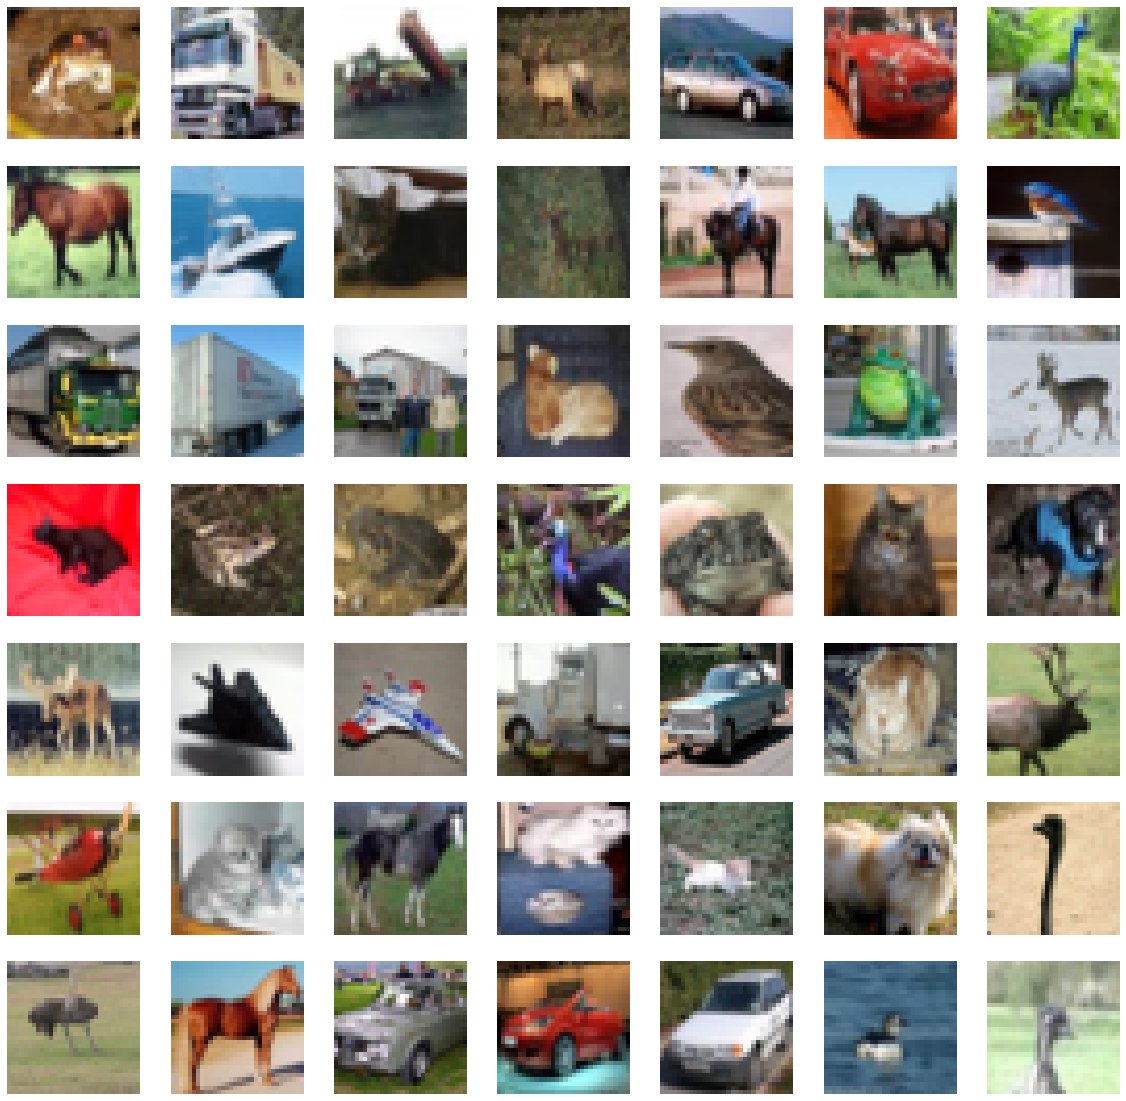

In [2]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)
# plot images from the training dataset
plt.figure( figsize=(20, 20))
for i in range(49):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i])
plt.show()

# Defining discriminator

Due to different input images sizes we can't followe paper's architecture and filter sizes so we use architecture presented in [this link](https://https://github.com/4thgen/DCGAN-CIFAR10):

Discriminator gets 32x32x3 images, downsample the throw strided convolutions and finally label them using a dense layer:

the architecture explained below:

    D: (128, 32, 32, 3) // input image shape with batch size 128
    D: (128, 16, 16, 64) // after conv2d 5x5 stride 2
    D: (128, 8, 8, 128) // after conv2d 5x5 stride 2
    D: (128, 4, 4, 256) // after conv2d 5x5 stride 2
    D: (128, 2, 2, 512) // after conv2d 5x5 stride 2
    D: (128, 2048) // flatten
    D: (128, 1) // sigmoid out

activation functions:

use LeakyReLUwith alpha = 0.2 after each CONV2dTranspose except for the last layer we use sigmoid for calissification purpose

BatchNormalization:

use BatchNormalization after each layer except first and last layer to avoid oscillation and model instability

for training discriminator we use Adam version of stochastic gradient descent with learning rate 0.001

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 256)        

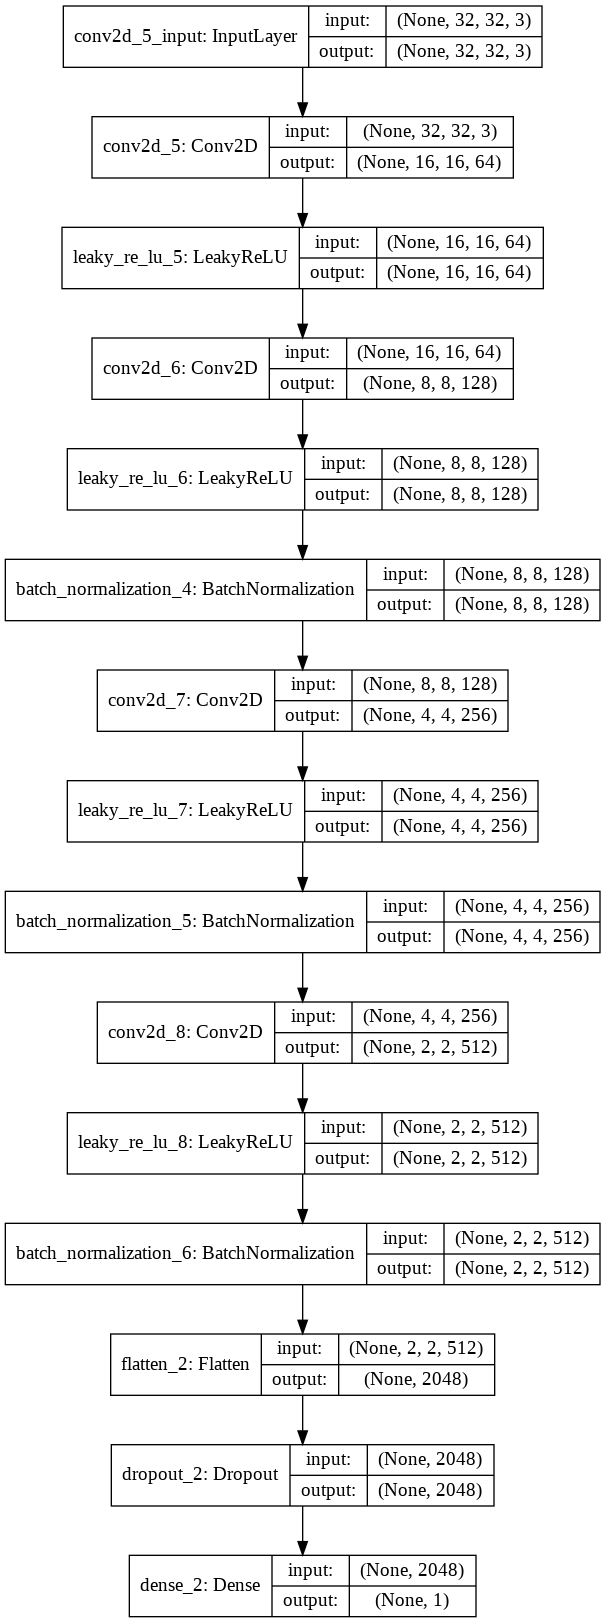

In [5]:
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  # downsample
  model.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  # downsample
  model.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,kernel_regularizer=l2(0.001), activation='sigmoid'))
    # compile model
  opt = Adam(lr=0.001, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',metrics.Precision(),metrics.Recall()])
  return model


d_model = define_discriminator()
d_model.summary()
plot_model(d_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# Defining generator
as mentioned in the refrence paper generator gets a vector of iid noises and path it through fractional strided convolution layers and outputs generated images.

the architecture explained below:


    G: (128, 100) // noise vector with batch size 128
    G: (128, 2048) // after linear
    G: (128, 2, 2, 512) // reshape
    G: (128, 4, 4, 256) // after conv2dTr 5x5 stride 2
    G: (128, 8, 8, 128) // after conv2dTr 5x5 stride 2
    G: (128, 16, 16, 64) // after conv2dTr 5x5 stride 2
    G: (128, 32, 32, 3) // after conv2dTr 5x5 stride 2 and tanh out


activation functions:

use LeakyReLUwith alpha = 0.2 after each CONV2dTranspose except for the last layer we use Tanh activation function to scale images to [-1,1]

BatchNormalization:

use BatchNormalization after each layer except first and last layer to avoid oscillation and model instability


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              206848    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 256)        

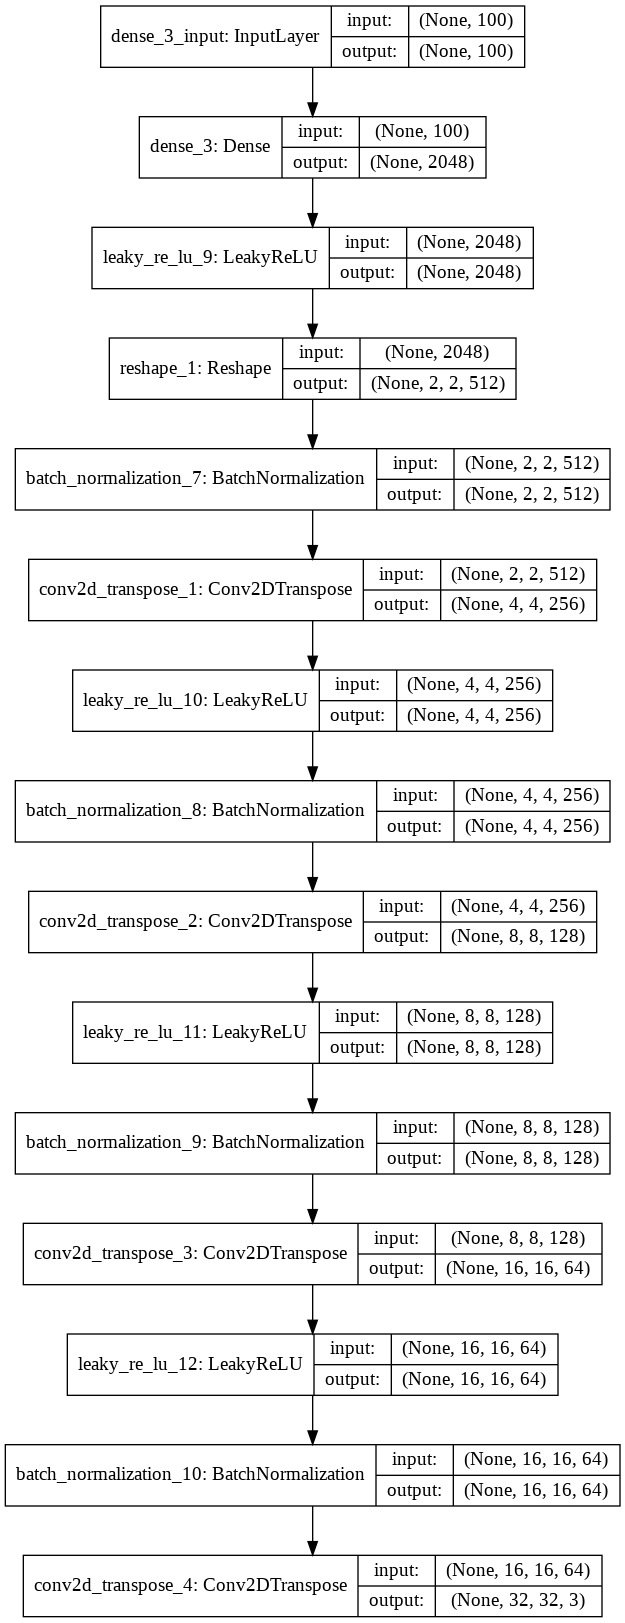

In [6]:

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 512 * 2 * 2
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((2, 2, 512)))
	model.add(BatchNormalization())
	# upsample to 4x4
	model.add(Conv2DTranspose(256, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization())
	# upsample to 8z8
	model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization())
	# upsample to 16x16
	model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization())
	# upsample to 32x32
	model.add(Conv2DTranspose(3, (5,5),strides=(2,2), activation='tanh', padding='same'))
	return model
latent_dim = 100
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


# training Discriminator

we pass real and fake images generated by generators to discriminator sepeately
using batch size of 128 images in each iteration we pass 64 real and 64 fake images to discriminator.

first we need to generate fake and real images:

generating real samples: 



In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = 0.9*ones((n_samples, 1))
	return X, y




generating fake samples: 


1.   creating noise vector from uniform(-1,1) distribution ( def generate_latent_points)
2.   passing noise vector to generator feedforward pass(def generate_fake_samples)


In [8]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = uniform(-1,1,latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

now that we have generated our training data we train discriminator:

In [9]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 

# trining Generator
to train generator we define new GAN model that stacks generator and discriminator. and do the followings:
1.  generate noise vector and pass in to generator
2.  pass generated images directly to discriminator
3.  use discriminator's output to update the generator's weights

tips:


*   we dont change discriminator weights using (d_model.trainable = False)
*   we update generator using adam optimizer with learning_rate = 0.0001 and binary_crossontropy loss function 




In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# training discriminator and generator together
we set discriminator learning rate to 0.001 bud generators learning rate to 0.0001 so as suggested in [this link](https://https://github.com/4thgen/DCGAN-CIFAR10) we train discriminator once and generator twice 

we use summarize_performance function to save GAN model and generated images every 10 epochs and calculate recall and precision every epoch.

# visualizing data

we use summarize_performance function to save GAN model and generated images every 10 epochs using (save_plot) and calculate recall and precision every epoch.

and finally after training we use plot_statistics to plot losses and accuracies

In [14]:

def train(g_model, d_model, gan_model, dataset, latent_dim,fake_loss,real_loss,fake_acc,real_acc,gen_loss,gen_acc,pre_list,rec_list, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, acc_real,_,_ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, acc_fake,_,_ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss1 = gan_model.train_on_batch(X_gan, y_gan)
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss2 = gan_model.train_on_batch(X_gan, y_gan)
		pre,rec = summarize_performance(i, g_model, d_model, dataset, latent_dim)

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X


# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	x = concatenate((X_real,x_fake),axis=0)
	y = concatenate((y_real,y_fake),axis=0)
	_,_,pre,rec = d_model.evaluate(x, y, verbose=0)
	print("epoch " + str(epoch))
	print('precision: %.3f, recall: %.3f ' % (pre,rec))
	if((epoch)%10==0):
		# save plot
		save_plot(x_fake, epoch)
		# save the generator model tile file
		filename = 'generator_model_%03d.h5' % (epoch)
		g_model.save(filename)
	return pre,rec

# train the generator and discriminator



def plot_statistics(fake_loss,real_loss,fake_acc,real_acc,gen_loss,gen_acc,pre_list,rec_list):
	fake_loss.append(d_loss2)
	real_loss.append(d_loss1)
	gen_loss.append(g_loss2)
	fake_acc.append(acc_fake)
	real_acc.append(acc_real)
	pre_list.append(pre)
	rec_list.append(rec)
	plt.figure()
	plt.plot(fake_loss,label = 'fake')
	plt.plot(real_loss,label = 'real')
	plt.plot(gen_loss, label = 'gen')
	plt.title('loss')
	plt.legend()
	plt.show()
	plt.figure()
	plt.plot(real_acc,label = 'real')
	plt.plot(fake_acc,label = 'fake')
	plt.title('acc')
	plt.legend()
	plt.show()
	plt.figure()
	plt.plot(pre_list,label = 'pre')
	plt.plot(rec_list,label = 'rec')
	plt.title('pre-rec')
	plt.legend()
	plt.show()	


and finally training model for 400 epochs and bach size of 128

In [ ]:
fake_loss = []
real_loss = []
fake_acc = []
real_acc = []
gen_loss = []
gen_acc = []
pre_list = []
rec_list = []
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,fake_loss,real_loss,fake_acc,real_acc,gen_loss,gen_acc,pre_list,rec_list)
plot_statistics(fake_loss,real_loss,fake_acc,real_acc,gen_loss,gen_acc,pre_list,rec_list)